## Data Roundup

Rerun the analysis done in [Linear SVC 12/20/2018](2018-12-20_LinearSVC.ipynb) and extract data needed for Derek's paper:

For cross validation (need both mean and standard deviation) and holdout:
* Accuracy
* Sensitivity
* Specificity
* PPV
* NPV
* Recall
* Precision
* Area Under the Curve
* Support

Also need ROC curve as a list of numbers.

Variable contribution (importance) to models (mean and standard deviation).

## Imports and Function Definitions

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1,1] / cm[:,1].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1,1] / cm[1,:].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')

## 1. Control vs. PD/MSA/PSP

In [5]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        50
          1       0.99      0.97      0.98       151

avg / total       0.97      0.97      0.97       201


recall	0.966887417219
precision	0.993197278912
auc	0.973443708609
specificity	0.993197278912
npv	0.966887417219
accuracy	0.970149253731


In [86]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.137223100662	0.0115379310875
score_time	0.026012468338	0.00201465189889
test_recall	0.926956521739	0.0255598929682
train_recall	0.95347826087	0.0048804226784
test_precision	0.985295789605	0.0108326901894
train_precision	0.992764996242	0.00165654153745
test_auc	0.945990338164	0.0191286048019
train_auc	0.967968938878	0.00191860957455
test_specificity	0.985295789605	0.0108326901894
train_specificity	0.992764996242	0.00165654153745
test_npv	0.926956521739	0.0255598929682
train_npv	0.95347826087	0.0048804226784
test_accuracy	0.937748447205	0.0203749193957
train_accuracy	0.961706951934	0.00287384393326


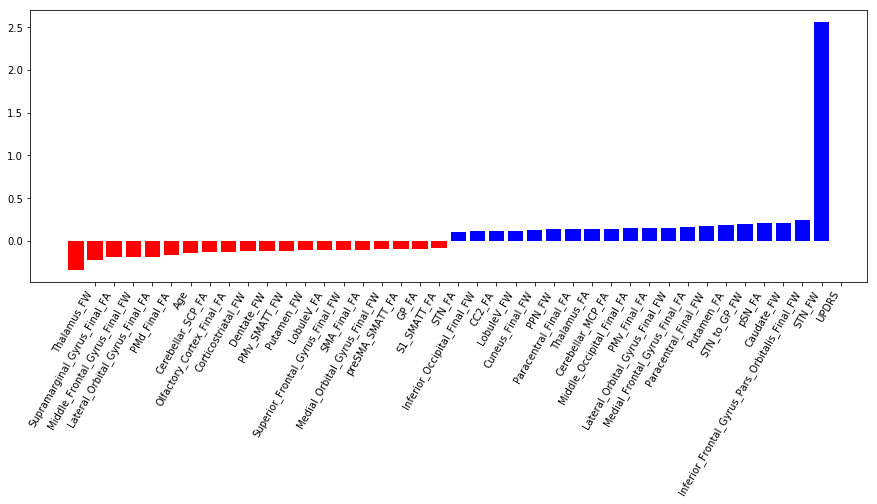

Age	-0.166956464469
Sex	-0.0141623902187
UPDRS	2.55362789872
aSN_FA	-0.0541848291354
Caudate_FA	-0.0775339351705
CC2_FA	0.109596794108
GP_FA	-0.0991481358296
LobuleVI_FA	0.0974993668405
LobuleV_FA	-0.110926934521
MCP_FA	0.0449648658663
pSN_FA	0.192491754872
Putamen_FA	0.169317666318
SCP_FA	0.036323093597
STN_FA	-0.08919730525
Thalamus_FA	0.136872214652
Vermis_FA	0.0411825101025
RN_FA	-0.0319954090121
PPN_FA	-0.0179328867816
Dentate_FA	-0.055795323743
CC1_FA	-0.0390703502859
aSN_FW	0.0790755450818
Caudate_FW	0.207074778678
CC2_FW	-0.0228324457776
GP_FW	-0.0513754877367
LobuleVI_FW	-0.0859803231855
LobuleV_FW	0.112110823367
MCP_FW	0.0189669431419
pSN_FW	0.0890995969444
Putamen_FW	-0.11465478857
SCP_FW	-0.0395626632616
STN_FW	0.23892465027
Thalamus_FW	-0.336067179984
Vermis_FW	-0.0125633769213
RN_FW	0.0107831184414
PPN_FW	0.123947293924
Dentate_FW	-0.12419767254
CC1_FW	-0.0315531398732
Angular_Gyrus_Final_FA	0.097098930269
Anterior_Orbital_Gyrus_Final_FA	-0.0589935760412
Calcarine_Sulcus_

In [87]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        50
          1       0.99      0.97      0.98       151

avg / total       0.97      0.97      0.97       201



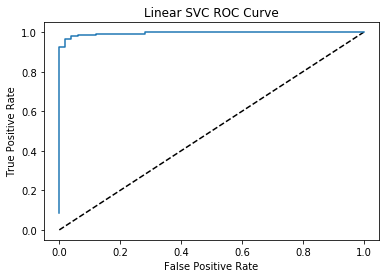

0.0 0.0860927152318
0.0 0.927152317881
0.02 0.927152317881
0.02 0.966887417219
0.04 0.966887417219
0.04 0.980132450331
0.06 0.980132450331
0.06 0.986754966887
0.12 0.986754966887
0.12 0.993377483444
0.28 0.993377483444
0.28 1.0
1.0 1.0


In [96]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [6]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.89      0.91       107
          1       0.73      0.85      0.79        39

avg / total       0.89      0.88      0.88       146


recall	0.846153846154
precision	0.733333333333
auc	0.867002156722
specificity	0.733333333333
npv	0.846153846154
accuracy	0.876712328767


In [7]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.104325723648	0.0355518337792
score_time	0.0309125423431	0.0125015729894
test_recall	0.814453781513	0.0458777354773
train_recall	0.900312793244	0.00813144793376
test_precision	0.814272551934	0.0740072379948
train_precision	0.877093385119	0.0259072076216
test_auc	0.865447306294	0.0227192186696
train_auc	0.923130440982	0.00557353839822
test_specificity	0.814272551934	0.0740072379948
train_specificity	0.877093385119	0.0259072076216
test_npv	0.814453781513	0.0458777354773
train_npv	0.900312793244	0.00813144793376
test_accuracy	0.886170760773	0.0257868574276
train_accuracy	0.932331053783	0.00810360503724


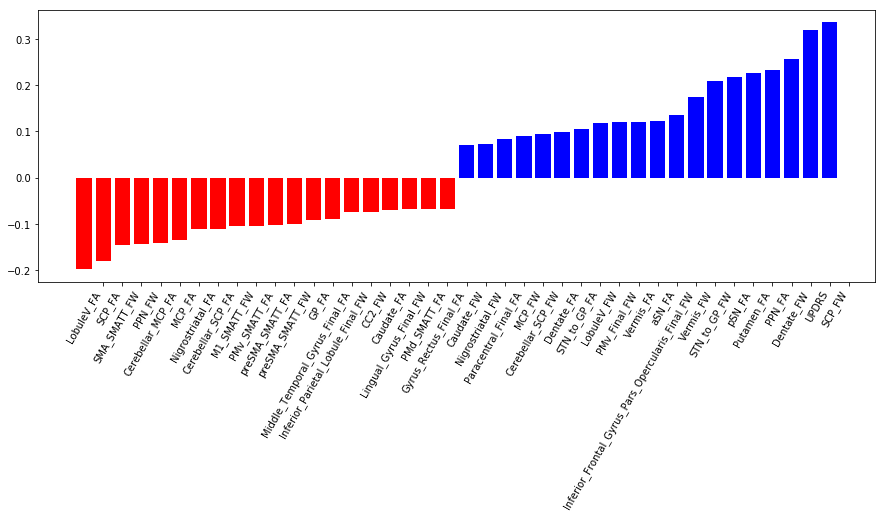

Age	-0.0475362839509
Sex	0.0
UPDRS	0.320733585149
aSN_FA	0.123111365163
Caudate_FA	-0.0703885191348
CC2_FA	0.0244864092836
GP_FA	-0.0923915332032
LobuleVI_FA	0.0368223850842
LobuleV_FA	-0.198903850691
MCP_FA	-0.134499020046
pSN_FA	0.218808969221
Putamen_FA	0.226541911599
SCP_FA	-0.181182129594
STN_FA	0.00430097166519
Thalamus_FA	-0.0204579510419
Vermis_FA	0.120701601881
RN_FA	-0.0282223190094
PPN_FA	0.232929619681
Dentate_FA	0.0986068660603
CC1_FA	-0.0124014762781
aSN_FW	0.0521028739457
Caudate_FW	0.0703276959636
CC2_FW	-0.0739070837844
GP_FW	0.0627346161367
LobuleVI_FW	-0.0117547674923
LobuleV_FW	0.117491311489
MCP_FW	0.0905462865803
pSN_FW	0.00838374263697
Putamen_FW	0.00373101199505
SCP_FW	0.337217094936
STN_FW	0.0634353028581
Thalamus_FW	0.0386903297107
Vermis_FW	0.174621292166
RN_FW	0.0104740517923
PPN_FW	-0.144657681224
Dentate_FW	0.257054211066
CC1_FW	-0.00628623971812
Angular_Gyrus_Final_FA	0.0238985423226
Anterior_Orbital_Gyrus_Final_FA	0.0600468032181
Calcarine_Sulcus_Final_F

In [8]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.94      0.89      0.91       107
          1       0.73      0.85      0.79        39

avg / total       0.89      0.88      0.88       146



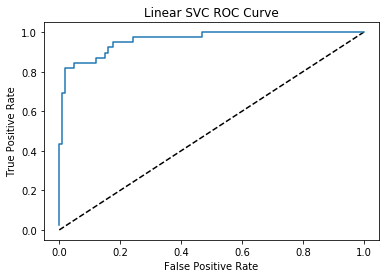

0.0 0.025641025641
0.0 0.435897435897
0.00934579439252 0.435897435897
0.00934579439252 0.692307692308
0.018691588785 0.692307692308
0.018691588785 0.820512820513
0.0467289719626 0.820512820513
0.0467289719626 0.846153846154
0.121495327103 0.846153846154
0.121495327103 0.871794871795
0.14953271028 0.871794871795
0.14953271028 0.897435897436
0.158878504673 0.897435897436
0.158878504673 0.923076923077
0.177570093458 0.923076923077
0.177570093458 0.948717948718
0.242990654206 0.948717948718
0.242990654206 0.974358974359
0.467289719626 0.974358974359
0.467289719626 1.0
1.0 1.0


In [9]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [10]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.98      0.91      0.95       134
          1       0.45      0.83      0.59        12

avg / total       0.94      0.90      0.92       146


recall	0.833333333333
precision	0.454545454545
auc	0.871890547264
specificity	0.454545454545
npv	0.833333333333
accuracy	0.904109589041


In [11]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.152495908737	0.0232657498904
score_time	0.0382875442505	0.00405511123289
test_recall	0.591428571429	0.138387211866
train_recall	0.785213032581	0.035740438035
test_precision	0.498470695971	0.0712419817997
train_precision	0.594531851731	0.0352392075914
test_auc	0.754460160302	0.0670326087988
train_auc	0.854789153473	0.0144124364661
test_specificity	0.498470695971	0.0712419817997
train_specificity	0.594531851731	0.0352392075914
test_npv	0.591428571429	0.138387211866
train_npv	0.785213032581	0.035740438035
test_accuracy	0.877581850101	0.0199795949676
train_accuracy	0.907330202905	0.00931838976884


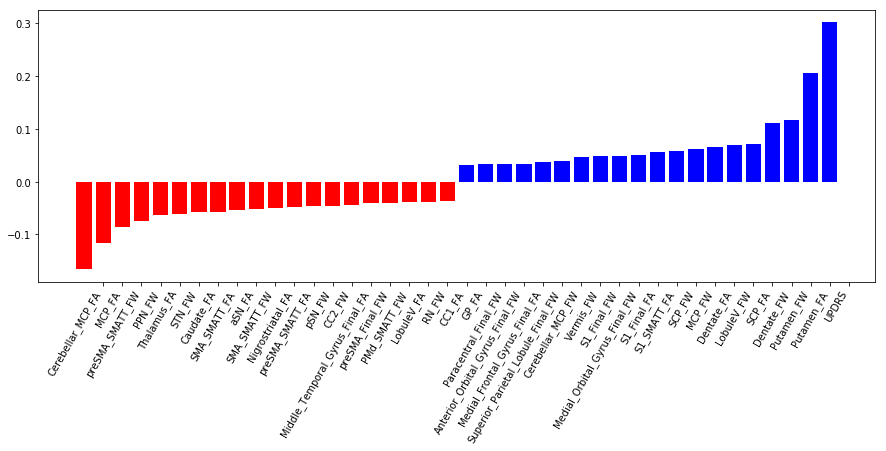

Age	0.0101543970067
Sex	0.0
UPDRS	0.302503002969
aSN_FA	-0.053122989631
Caudate_FA	-0.058734073667
CC2_FA	0.0205281601814
GP_FA	0.0313986527612
LobuleVI_FA	-0.0255896634724
LobuleV_FA	-0.0391378728131
MCP_FA	-0.116291318123
pSN_FA	0.0122888662461
Putamen_FA	0.206507267017
SCP_FA	0.071331479756
STN_FA	-0.017634024936
Thalamus_FA	-0.0626982051993
Vermis_FA	0.0191274459938
RN_FA	0.0151393588933
PPN_FA	-0.0323666498116
Dentate_FA	0.0648750148819
CC1_FA	-0.0368151290562
aSN_FW	-0.0261094371841
Caudate_FW	0.0257908563073
CC2_FW	-0.0461483597285
GP_FW	0.0135151344527
LobuleVI_FW	0.0253664501629
LobuleV_FW	0.0698770116761
MCP_FW	0.0624400720241
pSN_FW	-0.0468974798489
Putamen_FW	0.117502545917
SCP_FW	0.0586585437369
STN_FW	-0.0621111494789
Thalamus_FW	-0.00845941309399
Vermis_FW	0.045875424019
RN_FW	-0.038758882622
PPN_FW	-0.0745731409098
Dentate_FW	0.111640253153
CC1_FW	0.0112331155625
Angular_Gyrus_Final_FA	-0.0279551940384
Anterior_Orbital_Gyrus_Final_FA	0.00949994212333
Calcarine_Sulcus_Fi

In [12]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.98      0.91      0.95       134
          1       0.45      0.83      0.59        12

avg / total       0.94      0.90      0.92       146



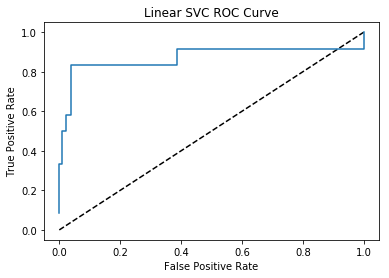

0.0 0.0833333333333
0.0 0.333333333333
0.00746268656716 0.333333333333
0.00746268656716 0.5
0.0223880597015 0.5
0.0223880597015 0.583333333333
0.0373134328358 0.583333333333
0.0373134328358 0.833333333333
0.388059701493 0.833333333333
0.388059701493 0.916666666667
1.0 0.916666666667
1.0 1.0


In [13]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [14]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      0.96      0.97       119
          1       0.83      0.89      0.86        27

avg / total       0.95      0.95      0.95       146


recall	0.888888888889
precision	0.827586206897
auc	0.923436041083
specificity	0.827586206897
npv	0.888888888889
accuracy	0.945205479452


In [15]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0755012512207	0.0105485531516
score_time	0.0233098983765	0.00457453563176
test_recall	0.804285714286	0.11059927462
train_recall	0.914272809395	0.0130325726397
test_precision	0.828224400871	0.079488342121
train_precision	0.867000616462	0.0361983787055
test_auc	0.882296365915	0.0459340719266
train_auc	0.941970246098	0.00742584862854
test_specificity	0.828224400871	0.079488342121
train_specificity	0.867000616462	0.0361983787055
test_npv	0.804285714286	0.11059927462
train_npv	0.914272809395	0.0130325726397
test_accuracy	0.932798985123	0.0135853420001
train_accuracy	0.959917360782	0.0077794595232


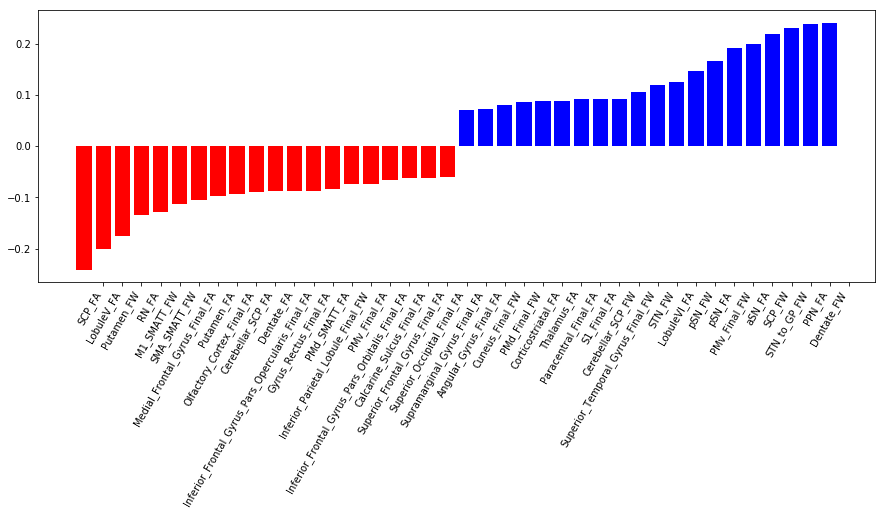

Age	0.00534323648215
Sex	0.0
UPDRS	-0.0145411600339
aSN_FA	0.200159078879
Caudate_FA	0.04932749748
CC2_FA	0.00797220425473
GP_FA	-0.0504709688547
LobuleVI_FA	0.125979885319
LobuleV_FA	-0.200127331502
MCP_FA	0.0600703398331
pSN_FA	0.16562582047
Putamen_FA	-0.097416954573
SCP_FA	-0.24142528706
STN_FA	-0.0321272489101
Thalamus_FA	0.0889685320531
Vermis_FA	0.0637327734177
RN_FA	-0.134068173836
PPN_FA	0.238442822289
Dentate_FA	-0.0884317870942
CC1_FA	-0.0385274612911
aSN_FW	0.00673330545647
Caudate_FW	-0.0478870839134
CC2_FW	0.0190889483787
GP_FW	0.0229976250967
LobuleVI_FW	-0.00883267828184
LobuleV_FW	-0.0378197091098
MCP_FW	0.0620107540274
pSN_FW	0.147083076393
Putamen_FW	-0.176318532681
SCP_FW	0.218147987657
STN_FW	0.118321188986
Thalamus_FW	0.0628862924994
Vermis_FW	0.0663078344781
RN_FW	0.0389172712558
PPN_FW	-0.00148666844879
Dentate_FW	0.240756827074
CC1_FW	-0.0278287422812
Angular_Gyrus_Final_FA	0.0722491098718
Anterior_Orbital_Gyrus_Final_FA	0.0703246276226
Calcarine_Sulcus_Final_F

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      0.96      0.97       119
          1       0.83      0.89      0.86        27

avg / total       0.95      0.95      0.95       146



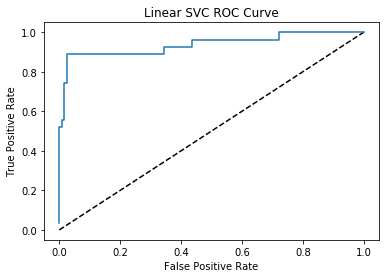

0.0 0.037037037037
0.0 0.518518518519
0.00840336134454 0.518518518519
0.00840336134454 0.555555555556
0.0168067226891 0.555555555556
0.0168067226891 0.740740740741
0.0252100840336 0.740740740741
0.0252100840336 0.888888888889
0.344537815126 0.888888888889
0.344537815126 0.925925925926
0.436974789916 0.925925925926
0.436974789916 0.962962962963
0.72268907563 0.962962962963
0.72268907563 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)